In [25]:
import scapy as scapy
from scapy.utils import PcapReader
from scapy import layers
import time
import os
from matplotlib import pyplot as plt

In [26]:
LOG = False

In [27]:
DUMP_DIRECTORY = "./tcpdump_logs/"
DLINT_1_PCAP = DUMP_DIRECTORY + "dlint_1_flow/5mbps.pcap"

assert os.path.exists(DLINT_1_PCAP), "The path to the pcap file is incorrect."

In [28]:
pcap = PcapReader(DLINT_1_PCAP)

delays = []

for index, pkt in enumerate(pcap):
    pkt: scapy.packet.Packet

    if pkt.haslayer(layers.inet.TCP):
        if LOG:
            print(pkt.getlayer(layers.inet.TCP).options)

        for option in pkt.getlayer(layers.inet.TCP).options:
            if option[0] == 114:
                delay = int(''.join([hex(x)[2:].zfill(2) for x in option[1]])[-8:], base=16)
                if delay == 0:
                    continue

                delays.append(delay)

                if LOG:
                    print(f"Operation: {option[0]}")
                    print(' '.join([hex(x)[2:].zfill(2) for x in option[1]]))
                    print(f"Delay: {delay}\n")

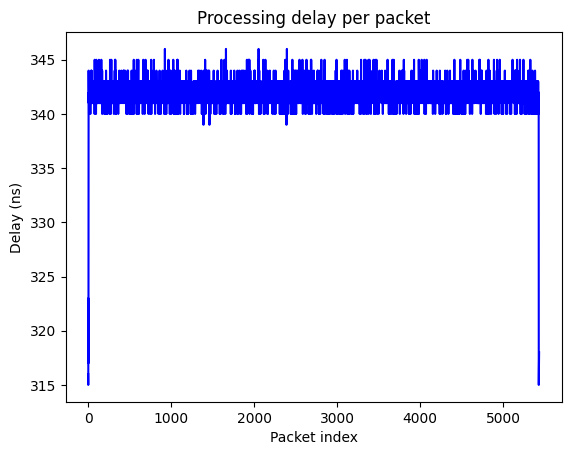

In [30]:
plt.plot(delays, color='blue', linestyle='solid')
plt.ylabel('Delay (ns)')
plt.xlabel('Packet index')
plt.title('Processing delay per packet')

plt.show()